## Datos
En este notebook, se desea cargar datos para entrenar un modelo de machine learning que permita predecir la valoración de vinos. Utilizaremos un conjunto de datos que contiene diversas características de los vinos, como la acidez, el contenido de azúcar, el pH, entre otros, y la valoración que han recibido. A partir de estos datos, entrenaremos un modelo que pueda predecir la valoración de un vino basado en sus características.

### Instalar librerias
Primero hay que descargar la libreria ucimlrepo que contiene datos para realizar entrenamiento automático

In [1]:
!pip install ucimlrepo

## Añadir librerias

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, r2_score, f1_score, roc_curve, RocCurveDisplay
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.datasets import make_multilabel_classification
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np

## Variables opcionales
<a name="precisiones"></a>

In [3]:
precisiones={}

## Funciones auxiliares


### Dibujar los puntos de los resultados
Permite comparar los valores esperados con los obtenidos para un modelo, de esta forma se puede saber como se comporta el modelo

In [4]:
def dibujar(y_test,y_pred,nombre):
  xx = np.array(list(range(y_test.shape[0])))
  plt.plot(xx, y_test,'ro', label='data')
  plt.plot(xx, y_pred, 'go', label='prediction')
  plt.axis('tight')
  plt.legend()
  plt.title(nombre)
  plt.show()

### Matríz de confusión
En una matriz de confusión, las columnas representan los valores previstos de una clase dada, mientras que las filas representan los valores reales (por ejemplo, datos reales) de una clase determinada, o viceversa. Tenga en cuenta que lo contrario también aparece en la investigación. Esta estructura de cuadrícula es una herramienta práctica para visualizar la precisión de la clasificación del modelo al mostrar el número de previsiones correctas e incorrectas para todas las clases una al lado de la otra.</br>
(https://www.ibm.com/mx-es/topics/confusion-matrix)


In [5]:
def matriz_confusion(y_test, y_pred,clases):
  cm = confusion_matrix(y_test, y_pred, labels=clases)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
  disp.plot()

<a name="F1"></a>
### Puntuación_F1
La puntuación F1 es la media armónica de la precisión y la recuperación. Proporciona una única puntuación que equilibra la precisión y la recuperación. Esta puntuación es especialmente útil cuando se desea encontrar un equilibrio entre precisión y recuperación o cuando las clases están desequilibradas. La puntuación F1 oscila entre 0 y 1, donde un valor más alto indica un mejor rendimiento.</br>(https://codelabsacademy.com/es/blog/key-metrics-for-classification-models)

In [6]:
puntuaciones_macro ={}
puntuaciones_micro ={}
puntuaciones_weighted ={}
def f1(y_test, y_pred, modelo):
  averages=['macro', 'micro', 'weighted']
  for a in averages:
    if a == 'macro':
      puntuaciones_macro.update({modelo:f1_score(y_test, y_pred, average=a)})
    elif a == 'micro':
      puntuaciones_micro.update({modelo: f1_score(y_test, y_pred, average=a)})
    elif a == 'weighted':
      puntuaciones_weighted.update({modelo:f1_score(y_test, y_pred, average=a)})
    print(a,": ",f1_score(y_test, y_pred, average=a))

<a name="ROC"></a>
### Curva ROC
Una curva ROC es una representación gráfica del rendimiento de un modelo de clasificación binaria para todos los umbrales de clasificación. El acrónimo ROC significa Receiver Operating Characteristic (Característica Operativa del Receptor).</br>(https://datatab.es/tutorial/roc-curve)

In [7]:
def curva_roc(y_test, y_pred, nombre, clases):
  """
  Generates and displays the ROC curve for multiclass classification.

  Args:
      y_test: True target values.
      y_pred: Predicted target values.
      nombre: Name of the classifier.
      clases: Unique classes in the target variable.
  """

  # Binarize the output
  from sklearn.preprocessing import label_binarize
  y_test_bin = label_binarize(y_test, classes=clases)
  y_pred_bin = label_binarize(y_pred, classes=clases)
  n_classes = y_test_bin.shape[1]

  # Compute ROC curve and ROC area for each class
  from sklearn.metrics import roc_curve, auc
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot ROC curve for micro-average
  plt.figure()
  lw = 2
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      color="darkorange",
      lw=lw,
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC Curve for {nombre} (Micro-Average)")
  plt.legend(loc="lower right")
  plt.show()

## Cargar los datos
Y para cargarlos desde Python, puede usarse el siguiente código:

In [4]:
# Descarga del dataset
wine_quality = fetch_ucirepo(id=186)
# Datos brutos en formato Dataframe de pandas
X = wine_quality.data.features
y = wine_quality.data.targets
#Metadatos
todos= [X,y]
todos = pd.concat(todos, axis=1)
print(wine_quality.data.features.shape)
wine_quality.data.features.describe()
# print(wine_quality.metadata)
#Información de lasvariables
# print(wine_quality.variables.shape)
# print(wine_quality.data.shape)

(6497, 11)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


## Visualizar los datos

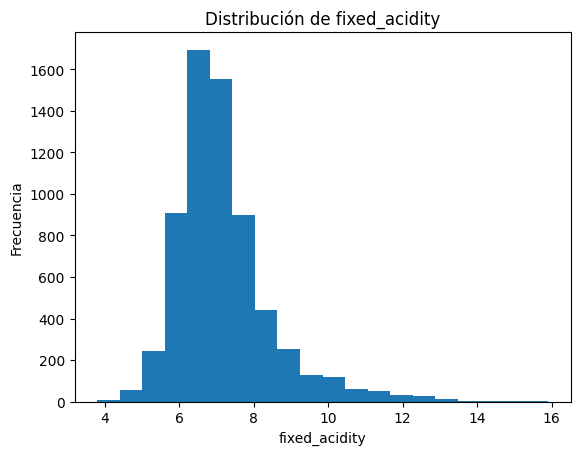

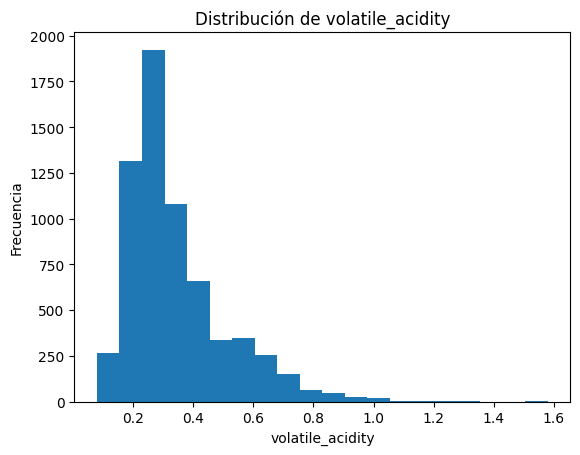

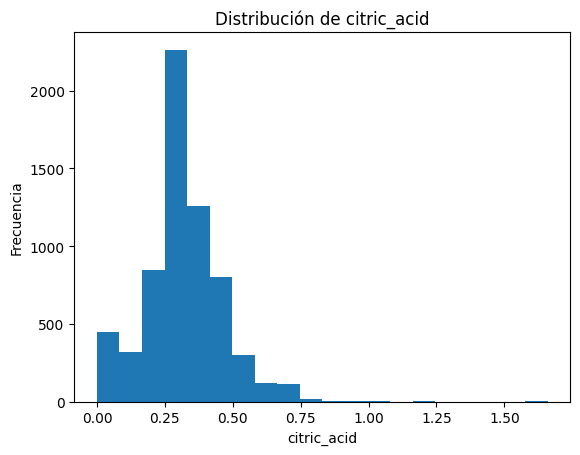

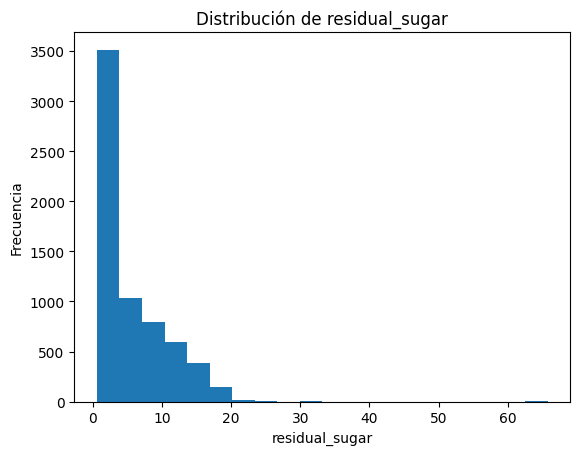

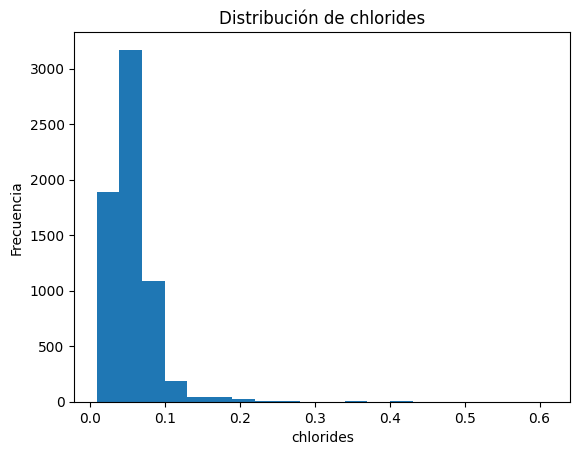

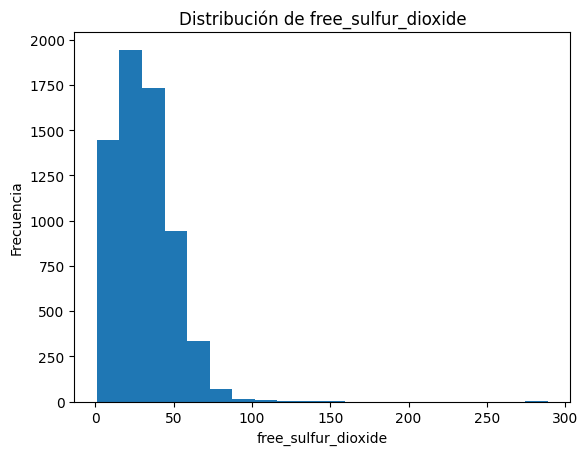

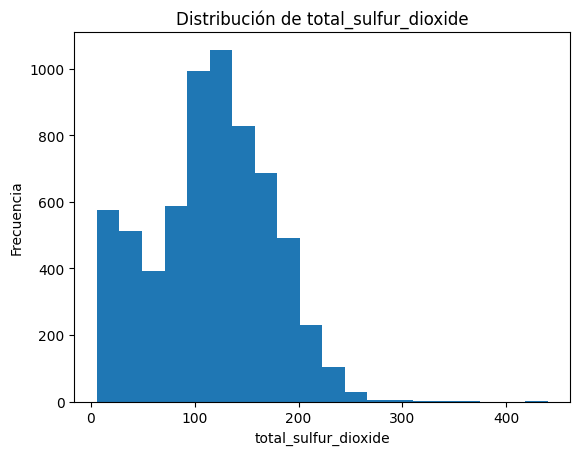

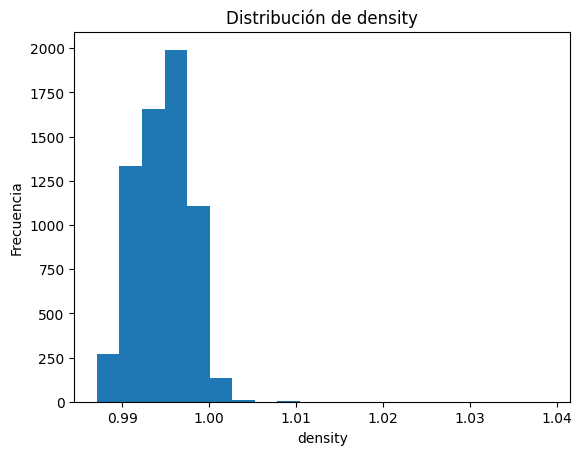

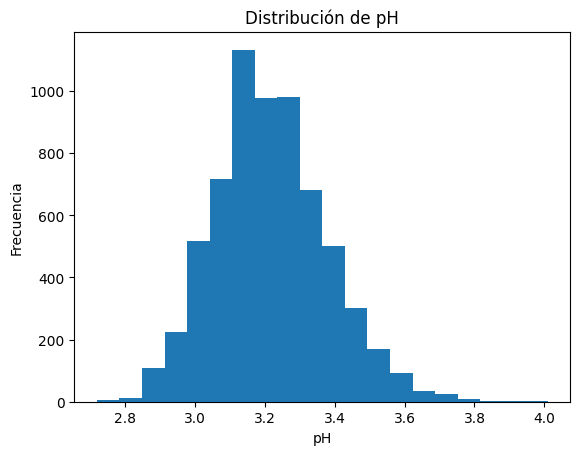

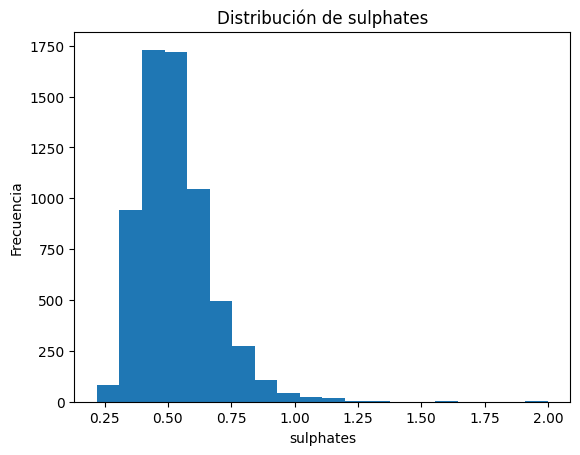

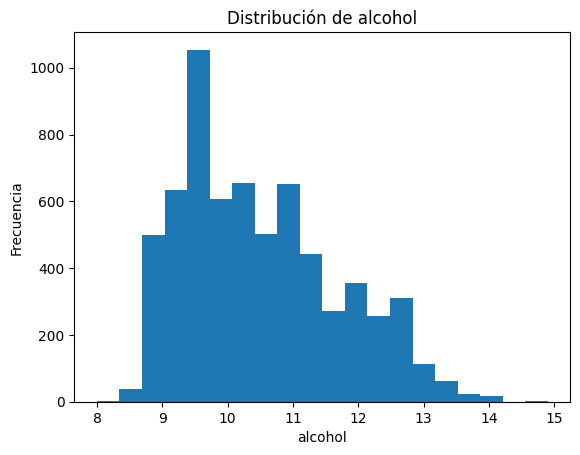

In [9]:
columnas = X.columns
for columna in columnas:
    # Crear una nueva figura
    plt.figure()

    # Generar la gráfica (histograma en este caso)
    plt.hist(X[columna], bins=20)  # Ajusta 'bins' según sea necesario

    # Añadir título y etiquetas
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

    # Mostrar la gráfica
    plt.show()

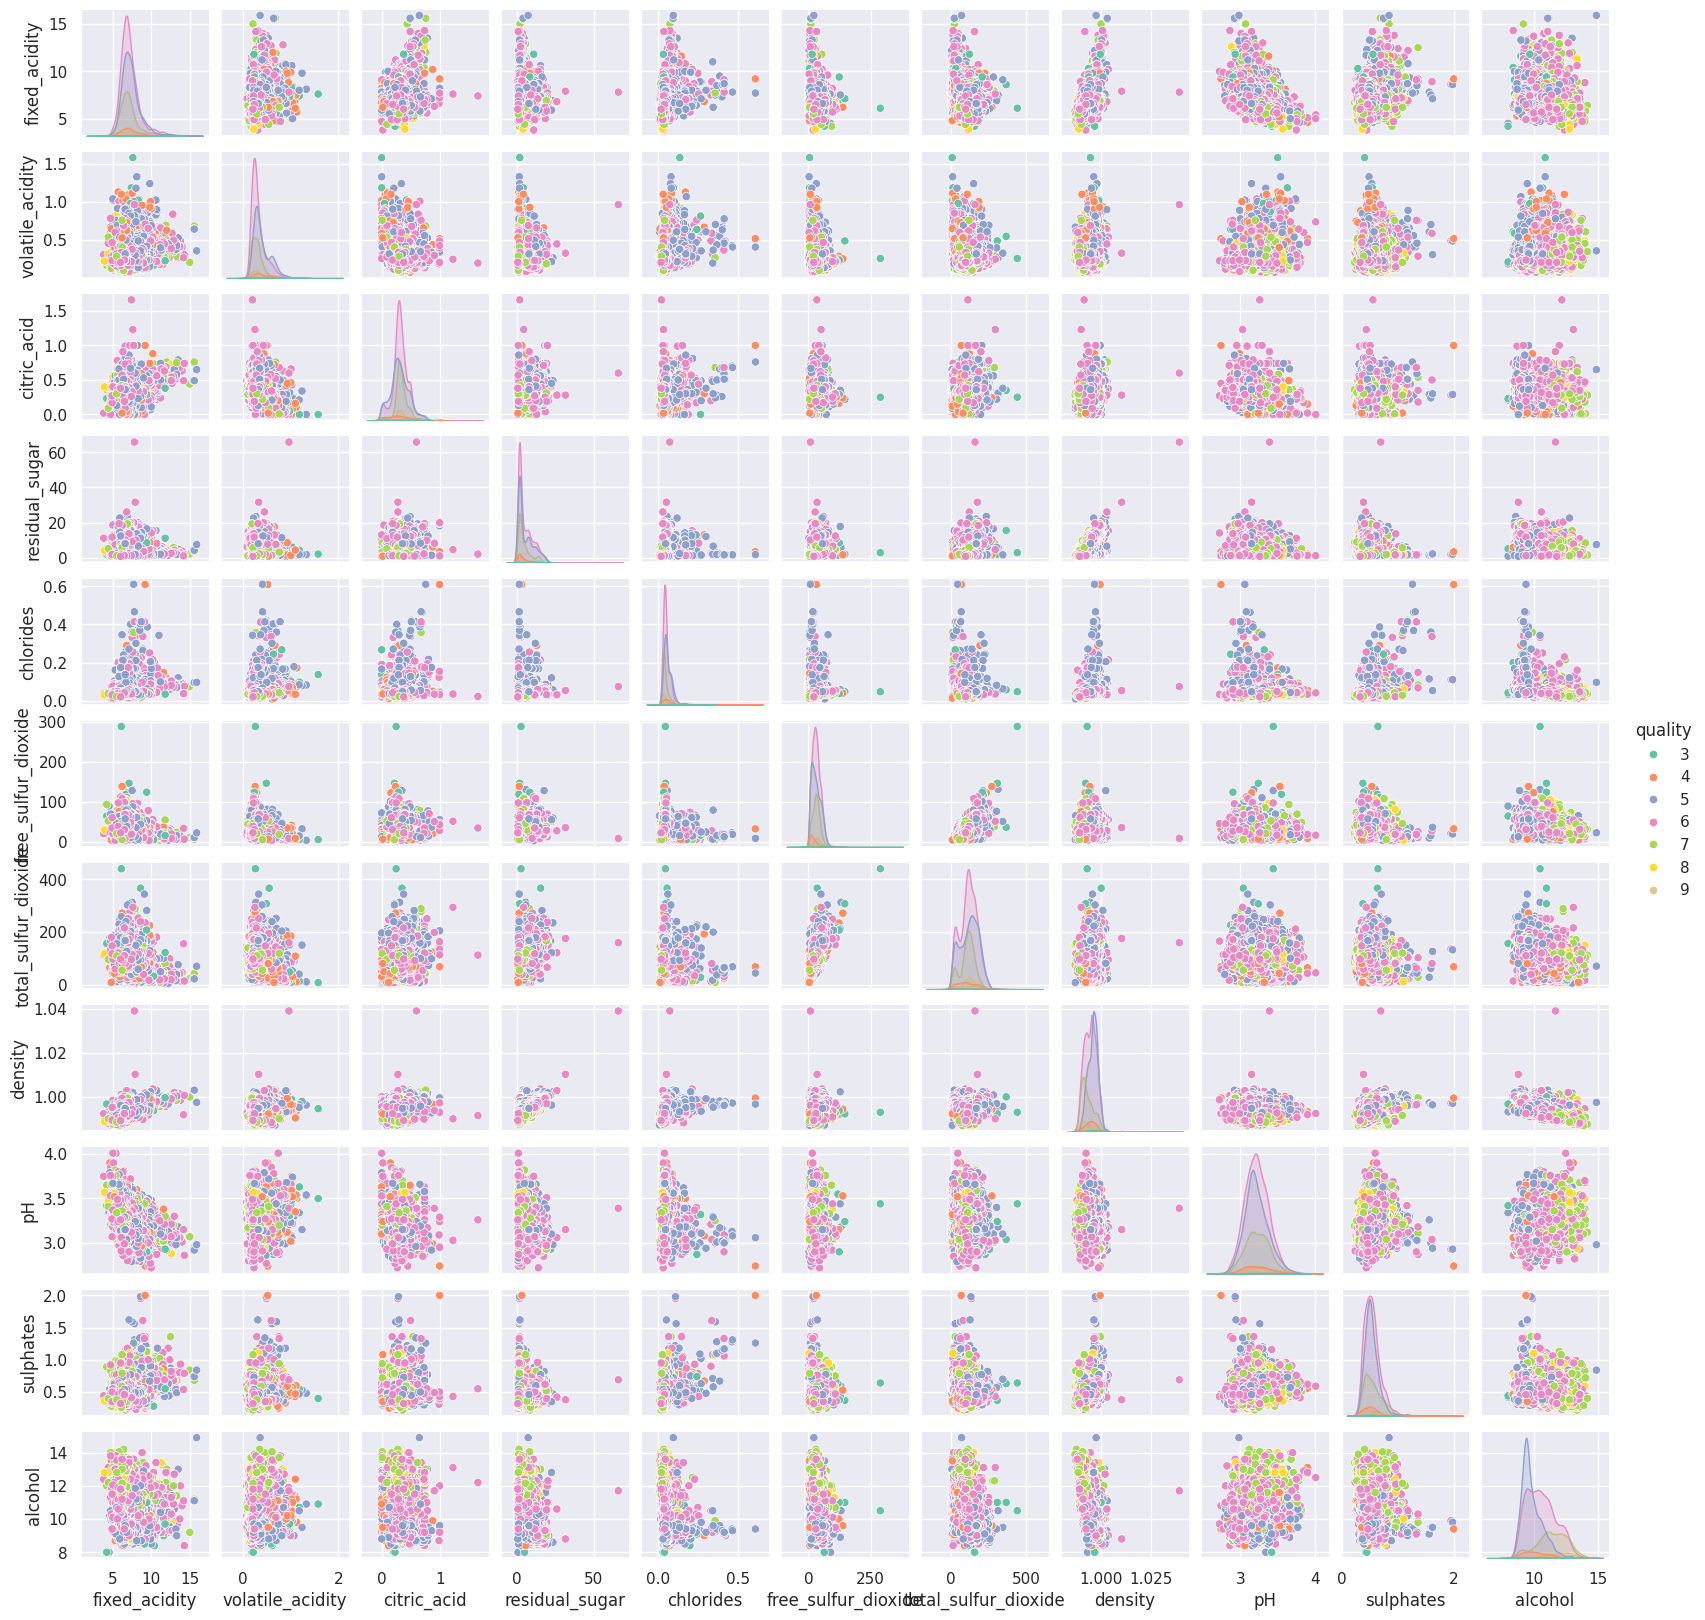

In [10]:
sns.set()
sns.pairplot(todos,palette="Set2", hue='quality', height=1.5);

### Análisis de los datos


#### Correlación de los datos
Dos caracteristicas que con una correlación muy alta o muy baja(cercana a ±1), implica que presentan comportamientos similares u opuestos en la misma magnitud

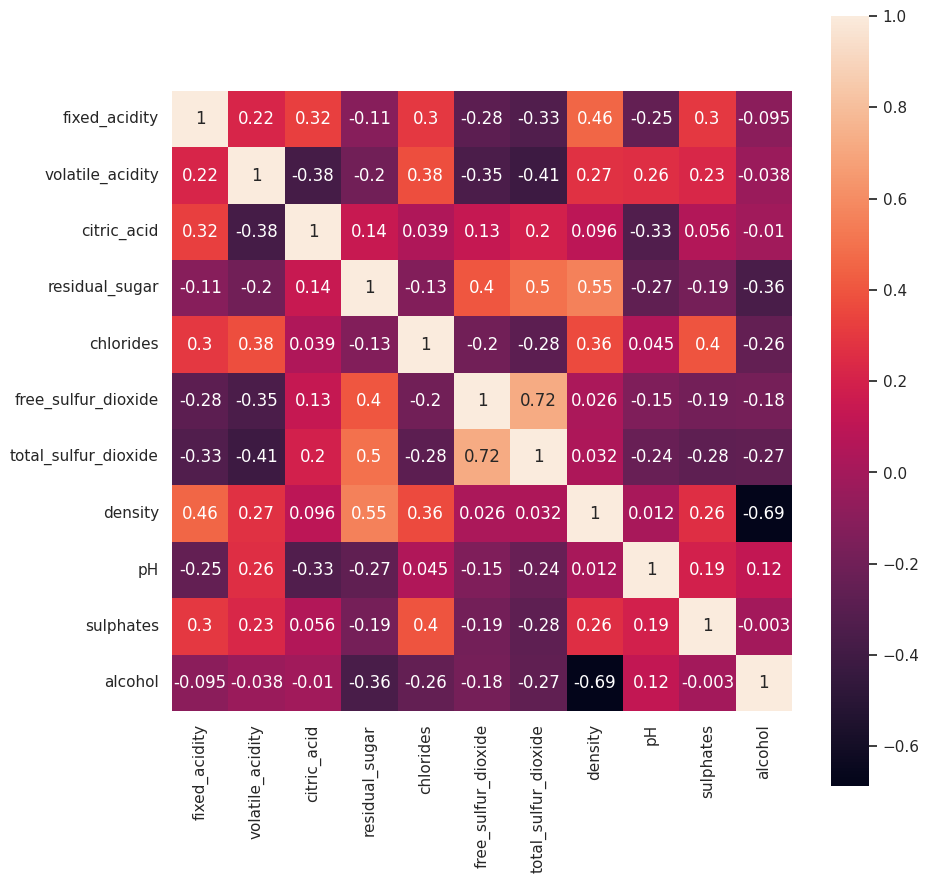

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
correlacion = X.corr()
sns.heatmap(correlacion, annot=True, square=True, ax= ax)
# Obten los elementos de X que tengan una correlación absoluta superior a 0.8 e inferior a 1
correlacion_absoluta = correlacion.abs()
correlacion_superior = correlacion_absoluta[(correlacion_absoluta > 0.8)&(correlacion_absoluta <1)]
correlacion_superior = correlacion_superior.stack().reset_index()
correlacion_superior.columns = ['Variable 1', 'Variable 2', 'Correlación']

In [12]:
if(correlacion_superior.empty):
  print("No hay correlación")
else:
  print(correlacion_superior)

No hay correlación


## Procesar los datos
Una vez hemos descargado los datos hay que procesarlos de forma que obtengamos 4 conjuntos distintos de datos. Esto es por la forma que tenemos de entrenar y evaluar los modelos, para ello hay que crear un conjunto de datos con las características y los resultados, por otra parte se genera otros dos conjuntos de datos(uno con características y otro con resultados) para evaluar el modelo y obtener métricas que permitan determinar la calidad del mismo.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X.describe()
# print(X_train.head())
# print(y_train.head())
# print(X_test.head())
# print(y_test.head())

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


## Elección de algoritmo


<a name="Regresión"></a>
### Regresión
 La regresión es la parte del aprendizaje supervisado que se ocupa de la predicción de valores numéricos
 continuos. En este caso, el objetivo del algoritmo es inferir las relaciones entre las variables, que se conocen
 previamente y que permiten ofrecer una predicción sobre la salida requerida.

#### SVM
Una máquina de vectores de soporte (SVM) es un algoritmo de machine learning supervisado que clasifica los datos mediante la búsqueda de una línea o un hiperplano óptimos que maximice la distancia entre cada clase en un espacio N-dimensional.</br>(https://www.ibm.com/es-es/think/topics/support-vector-machine#:~:text=Una%20m%C3%A1quina%20de%20vectores%20de%20soporte%20%28SVM%29%20es,distancia%20entre%20cada%20clase%20en%20un%20espacio%20N-dimensional.)

<a name="SVMLineal"></a>
#### SVM(LinearSVR)
Las SVM lineales se utilizan con datos separables linealmente; esto significa que los datos no necesitan sufrir ninguna transformación para separarlos en diferentes clases.</br>
(https://www.ibm.com/es-es/think/topics/support-vector-machine#:~:text=Una%20m%C3%A1quina%20de%20vectores%20de%20soporte%20%28SVM%29%20es,distancia%20entre%20cada%20clase%20en%20un%20espacio%20N-dimensional.)

#### KNN
El algoritmo k vecinos más cercanos (KNN) es un clasificador de aprendizaje supervisado no paramétrico que utiliza la proximidad para hacer clasificaciones o predicciones sobre la agrupación de un punto de datos individual.</br>(https://www.ibm.com/es-es/topics/knn)

#### Decision Tree
Un árbol de decisión es un algoritmo de aprendizaje supervisado no paramétrico, que se utiliza tanto para tareas de clasificación como de regresión. Tiene una estructura jerárquica de árbol, que consta de un nodo raíz, ramas, nodos internos y nodos hoja.
(https://www.ibm.com/es-es/think/topics/decision-trees)

In [14]:
modelos = {"SVM":SVR(), "SVMLinear": SVR(kernel="linear"), "KNN": KNeighborsRegressor(), "Decision Tree": DecisionTreeRegressor()}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVMLinear


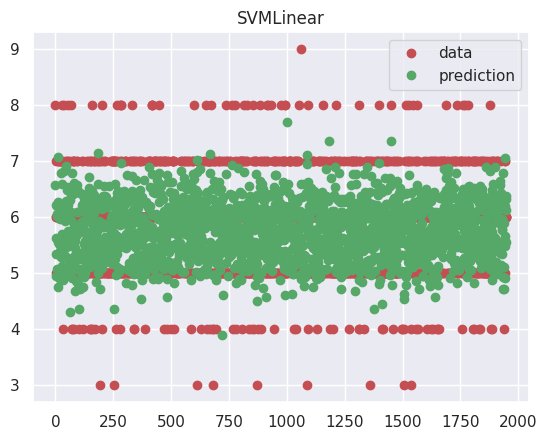

SVMLinear: mae = 0.5639017714071852
SVMLinear: r2 = 0.2664743397883892
SVMLinear: MSE = 0.535209643426184


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM


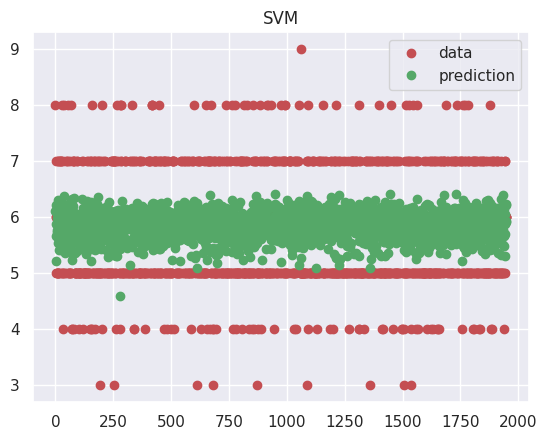

SVM: mae = 0.6075501266414263
SVM: r2 = 0.15726737482277997
SVM: MSE = 0.6148914104717131
KNN


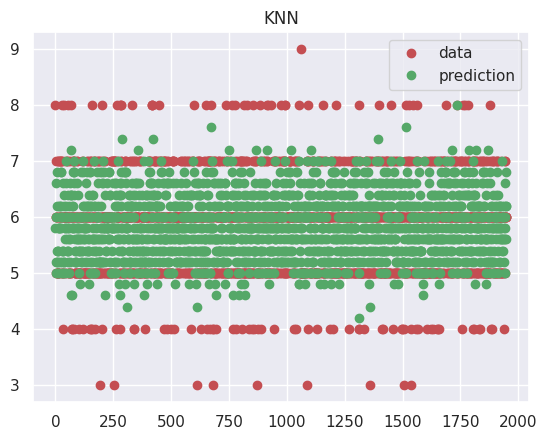

KNN: mae = 0.6243076923076923
KNN: r2 = 0.12209600728935688
KNN: MSE = 0.6405538461538461
Decision Tree


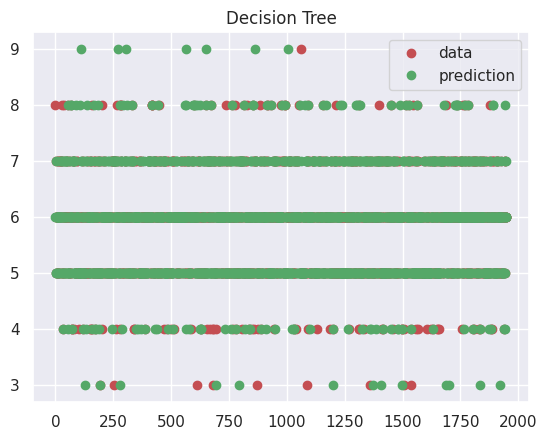

Decision Tree: mae = 0.4805128205128205
Decision Tree: r2 = 0.058896590899260914
Decision Tree: MSE = 0.6866666666666666


In [18]:
mae_scores = {}
mse_scores = {}
r2_scores = {}
for nombre, modelo in modelos.items():
  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)
  # y_pred.head()
  print(nombre)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mae_scores[nombre] = mae
  mse_scores[nombre] = mse
  r2_scores[nombre] = r2
  try:
    dibujar(y_test,y_pred,nombre)
  except NameError:
    print(f"La función 'dibujar' no está definida.")
  print(f"{nombre}: mae = {mae}")
  print(f"{nombre}: r2 = {r2}")
  print(f"{nombre}: MSE = {mse}")

<a name="Clasificación"></a>
### Clasificación
La variable a predecir tiene una naturaleza cualitativa y por
 tanto lo que queremos averiguar es a qué grupo, clase o categoría pertenece
 el objeto/sujeto con un vector de características.


#### Naive bayes


In [6]:
nombre = "GaussianNB"
precisiones = {}
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({"GaussianNB": accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")

try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")
# hACER MSE
#HACER R_2

La función 'dibujar' no está definida.
Accuracy: 0.4687179487179487
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### SVM (LinearSVC)

In [7]:
nombre = "LinearSVC"
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está ejecutada.")
accuracy = accuracy_score(y_test, y_pred)
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred,nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")
try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

La función 'dibujar' no está ejecutada.
Accuracy: 0.5205128205128206
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


####SVC

In [8]:
nombre = "SVC"
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
try:
  dibujar(y_test,y_pred, nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({"SVC": accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred,nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")

try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.4564102564102564
La función 'dibujar' no está definida.
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


#### KNN
El algoritmo k vecinos más cercanos (KNN) es un clasificador de aprendizaje supervisado no paramétrico que utiliza la proximidad para hacer clasificaciones o predicciones sobre la agrupación de un punto de datos individual.
(https://www.ibm.com/es-es/topics/knn)

In [9]:
nombre = "KNeighborsClassifier"
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")

try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

La función 'dibujar' no está definida.
Accuracy: 0.4748717948717949
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


#### Desicion Tree

In [10]:
nombre = "DecisionTreeClassifier"
criterions =["gini", "entropy", "log_loss"]
splitters = ["random","best"]
max_featuress= ["sqrt", "log2"]
param_grid = {
    'criterion': criterions,
    'splitter': splitters,
    'max_features': max_featuress
}
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier( random_state=0),
    param_grid=param_grid,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = grid_search.best_score_
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Best parameters:", best_params)
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")
try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


La función 'dibujar' no está definida.
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}
Accuracy: 0.5647727849708047
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


#### Random Forest

In [11]:
nombre = "RandomForestClassifier"
tree = RandomForestClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, max_features=0.8, bootstrap=True, bootstrap_features=False,
                        random_state=1)
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")
try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:878: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


La función 'dibujar' no está definida.
Accuracy: 0.6733333333333333
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


#### Multi class

#####  OneVsRest

In [12]:
nombree = "OneVsRestClassifier"
model = OneVsRestClassifier(DecisionTreeClassifier(criterion="entropy", splitter="best"))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")
try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")


La función 'dibujar' no está definida.
Accuracy: 0.5271794871794871
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


##### OneVsOneClassifier

In [13]:
nombre= "OneVsOneClassifier"
model = OneVsOneClassifier(DecisionTreeClassifier(criterion="entropy", splitter="best"))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")
try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


La función 'dibujar' no está definida.
Accuracy: 0.5953846153846154
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


##### OutputCodeClassifier

In [14]:
nombre = "OutputCodeClassifier"
model = OutputCodeClassifier(DecisionTreeClassifier(criterion="entropy", splitter="best"))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Accuracy:", accuracy)
try:
  matriz_confusion(y_test, y_pred, model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")
try:
  curva_roc(y_test, y_pred, nombre, model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


La función 'dibujar' no está definida.
Accuracy: 0.5933333333333334
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


#### Multi Output

In [15]:
nombre = "MultiOutputClassifier"
model = MultiOutputClassifier(SVC())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
try:
  dibujar(y_test,y_pred,nombre)
except NameError:
  print(f"La función 'dibujar' no está definida.")
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("Accuracy:", accuracy)
labels = [label for sublist in model.classes_ for label in sublist]
labels = list(set(labels))
try:
  matriz_confusion(y_test, y_pred, labels)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")
try:
  curva_roc(y_test, y_pred, nombre, labels)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

La función 'dibujar' no está definida.
Accuracy: 0.4564102564102564
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


<a name="Mejor"></a>
#### Optimización de hiperparámetros

In [16]:
nombre= "BaggingClassifier"
bootstrap = [True, False]
n_estimators = [200, 400, 600]

param_grid = {
    'bootstrap': bootstrap,
    'n_estimators': n_estimators
}
grid_search = GridSearchCV(
    estimator=BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_features='sqrt'),random_state=1),
    param_grid=param_grid,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = grid_search.best_score_
print("Best parameters:", best_params)
print("Accuracy:", accuracy)
try:
  precisiones.update({nombre: accuracy})
except NameError:
  print(f"La variable 'precisiones' no está definida.")
try:
  matriz_confusion(y_test, y_pred, best_model.classes_)
except NameError:
  print(f"La funcion 'matriz_confusion' no está ejecutada.")
try:
  f1(y_test, y_pred, nombre)
except NameError:
  print(f"La funcion 'f1' no está ejecutada.")

try:
  curva_roc(y_test, y_pred, nombre, best_model.classes_)
except NameError:
  print(f"La funcion 'curva_roc' no está ejecutada.")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'bootstrap': True, 'n_estimators': 600}
Accuracy: 0.654063274459314
La funcion 'matriz_confusion' no está ejecutada.
La funcion 'f1' no está ejecutada.
La funcion 'curva_roc' no está ejecutada.


## Comparación

### Regresión
#### Error Absoluto Medio
Promedio de las diferencias absolutas entre los valores predichos y los valores reales</br>(https://es.statisticseasily.com/glosario/%C2%BFQu%C3%A9-significa-error-absoluto-mae%3F/)
<a name="ErrorCuadráticoMedio"></a>
#### Error Cuadrático Medio
Mide la diferencia cuadrática media entre los valores predichos y los valores reales de un conjunto de datos. El cuadrado de la diferencia se utiliza para garantizar que se tienen en cuenta tanto los errores positivos como los negativos.
Un MSE más alto indica que las predicciones del modelo están más alejadas de los valores reales, lo que indica un ajuste deficiente.</br>(https://shallbd.com/es/el-error-cuadratico-medio-que-le-dice-y-como-interpretarlo/)
<a name="Coeficientededeterminación"></a>
#### Coeficiente de determinación ($R^2$)
El coeficiente de determinación, cuyo símbolo es R2 (R cuadrado), es un estadístico que mide la bondad de ajuste de un modelo de regresión. El coeficiente de determinación muestra lo bien que se ajusta un modelo de regresión a un conjunto de datos, es decir, indica el porcentaje explicado por el modelo de regresión.</br>(https://www.probabilidadyestadistica.net/coeficiente-de-determinacion-r-cuadrado/)

In [12]:
try:
  print("MAE")
  print(mae_scores) #Use dictionary previously defined
  clave_min = min(mae_scores, key=mae_scores.get) #Use dictionary previously defined
  valor_min = mae_scores[clave_min] #Use dictionary previously defined
  print(clave_min, valor_min)
  print("===========================================================")
except NameError:
  print(f"La variable 'mae_scores' no está definida.") #Updated variable name
  print("===========================================================")
try:
  print("MSE")
  print(mse_scores) #Use dictionary previously defined
  clave_min = min(mse_scores, key=mse_scores.get) #Use dictionary previously defined
  valor_min = mse_scores[clave_min] #Use dictionary previously defined
  print(clave_min, valor_min)
except NameError:
  print(f"La variable 'mse_scores' no está definida.") #Updated variable name
  print("===========================================================")
print("===========================================================")
print("R2")
try:
  print(r2_scores) #Use dictionary previously defined
  clave_max = max(r2_scores, key=r2_scores.get) #Use dictionary previously defined
  valor_max = r2_scores[clave_max] #Use dictionary previously defined
  print(clave_max, valor_max)
except NameError:
  print(f"La variable 'r2_scores' no está definida.") #Updated variable name


MAE
{'SVMLinear': 0.5639017714071852, 'SVM': 0.6075501266414263, 'KNN': 0.6243076923076923, 'Decision Tree': 0.48512820512820515}
Decision Tree 0.48512820512820515
MSE
{'SVMLinear': 0.535209643426184, 'SVM': 0.6148914104717131, 'KNN': 0.6405538461538461, 'Decision Tree': 0.6892307692307692}
SVMLinear 0.535209643426184
R2
{'SVMLinear': 0.2664743397883892, 'SVM': 0.15726737482277997, 'KNN': 0.12209600728935688, 'Decision Tree': 0.05538238847543442}
SVMLinear 0.2664743397883892


### Clasificación
Hace referencia a
[F1](#F1) y las [precisiones](#precisiones)

In [17]:
# prompt: get the biggest value on precisiones
try:
  print("precisiones")
  print(precisiones)
  clave_max = max(precisiones, key=precisiones.get)
  valor_max = precisiones[clave_max]
  print(clave_max, valor_max)
except NameError:
  print(f"La variable 'precisiones' no está definida.")
print("===========================================================")
print("Puntuaciones F1")
print("===========================================================")
try:
  print("puntuaciones macro")
  print(puntuaciones_macro)
  clave_max = max(puntuaciones_macro, key=puntuaciones_macro.get)
  valor_max = puntuaciones_macro[clave_max]
  print(clave_max, valor_max)
except NameError:
  print(f"La variable 'puntuaciones_macro' no está definida.")
try:
  print("puntuaciones micro")
  print(puntuaciones_micro)
  clave_max = max(puntuaciones_micro, key=puntuaciones_micro.get)
  valor_max = puntuaciones_micro[clave_max]
  print(clave_max, valor_max)
except NameError:
  print(f"La variable 'puntuaciones_micro' no está definida.")
try:
  print("puntuaciones weighted")
  print(puntuaciones_weighted)
  clave_max = max(puntuaciones_weighted, key=puntuaciones_weighted.get)
  valor_max = puntuaciones_weighted[clave_max]
  print(clave_max, valor_max)
except NameError:
  print(f"La variable 'puntuaciones_weighted' no está definida.")

precisiones
{'GaussianNB': 0.4687179487179487, 'LinearSVC': 0.5205128205128206, 'SVC': 0.4564102564102564, 'KNeighborsClassifier': 0.4748717948717949, 'DecisionTreeClassifier': np.float64(0.5647727849708047), 'RandomForestClassifier': 0.5271794871794871, 'OneVsOneClassifier': 0.5953846153846154, 'OutputCodeClassifier': 0.5933333333333334, 'MultiOutputClassifier': 0.4564102564102564, 'BaggingClassifier': np.float64(0.654063274459314)}
BaggingClassifier 0.654063274459314
Puntuaciones F1
puntuaciones macro
La variable 'puntuaciones_macro' no está definida.
puntuaciones micro
La variable 'puntuaciones_micro' no está definida.
puntuaciones weighted
La variable 'puntuaciones_weighted' no está definida.


## Comparación
Teniendo en cuenta la naturaleza del ejercicio y considerando que la caracteristica a predecir es una variable discreta, considero que lo más optimo sería optar por modelos de [clasificación](#Clasificación) en lugar de los de [regresión](#Regresión).</br>
De entre los modelo de [clasificación](#Clasificación) el que tiene una mayor tasa de aciertos es el [BaggingClassifier](#Mejor) con una tasa de aciertos del 65%.
Este es el mejor en cualquier medida que se realiza tanto en [f1](#F1) como en la curva [ROC](#ROC)
Entre los de [regresión](#Regresión) El mejor es el [SVMLineal](#SVMLineal) al obtener una mayor puntuación en el [Coeficiente de determinación](#Coeficientededeterminación) y una menor en el [Error Cuadrático Medio](#ErrorCuadráticoMedio)